<a href="https://colab.research.google.com/github/MHC-FA24-CS341CV/beyond-the-pixels-emerging-computer-vision-research-topics-fa24/blob/main/VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Libraries and Upload Dataset**

In [1]:
# Import necessary libraries
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, BertTokenizer, BertForSequenceClassification
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import zipfile
from google.colab import files
import os

# Prompt user to upload the dataset.zip file containing images and question-answer pairs
print("Please upload the dataset.zip file")
uploaded = files.upload()

# Extract dataset if uploaded successfully
if 'dataset.zip' in uploaded:
    with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset')
    print("Dataset extracted successfully!")
else:
    print("Dataset zip file not found. Please upload again.")


Please upload the dataset.zip file


Saving dataset.zip to dataset.zip
Dataset extracted successfully!


**Step 2: Load and Display Dataset (Images, Questions, Answers)**

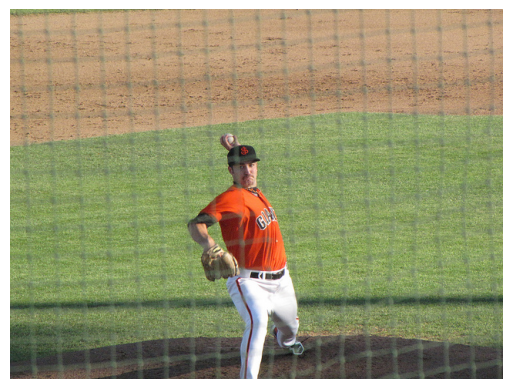

Question: What is this photo taken looking through?
Answers: net, net, net


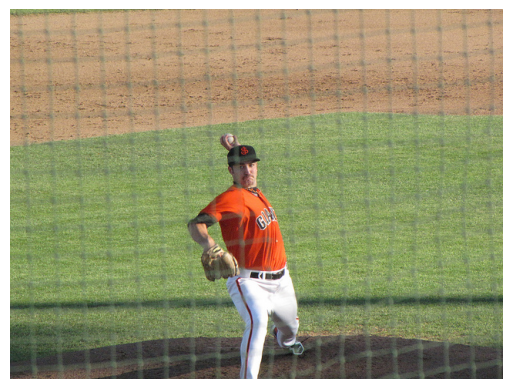

Question: What position is this man playing?
Answers: pitcher, catcher, pitcher


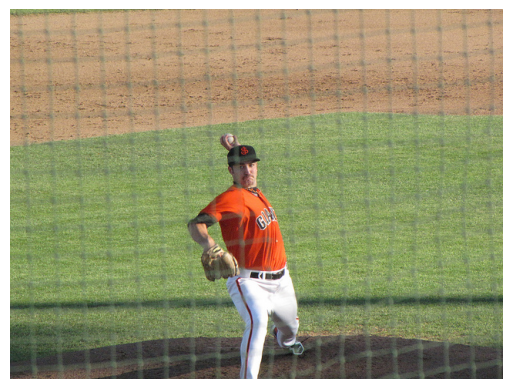

Question: What color is the players shirt?
Answers: orange, orange, orange


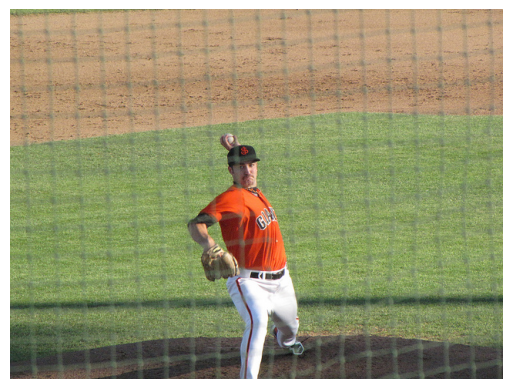

Question: Is this man a professional baseball player?
Answers: yes, yes, yes


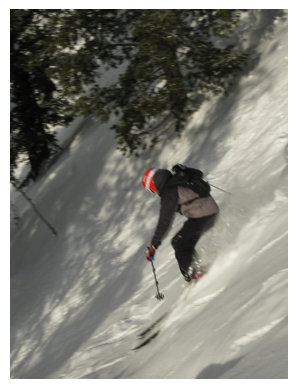

Question: What color is the snow?
Answers: white, white, white


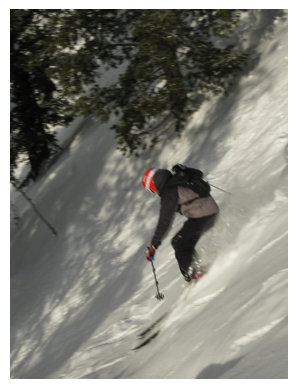

Question: What is the person doing?
Answers: skiing, skiing, skiing


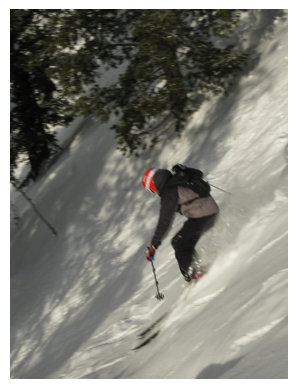

Question: What color is the persons headwear?
Answers: red, red, red & white


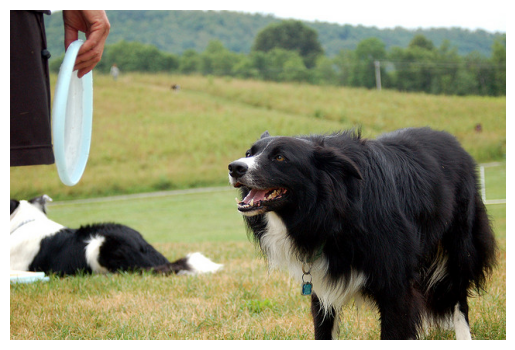

Question: What is in the person's hand?
Answers: frisbee, frisbee, white frisbee


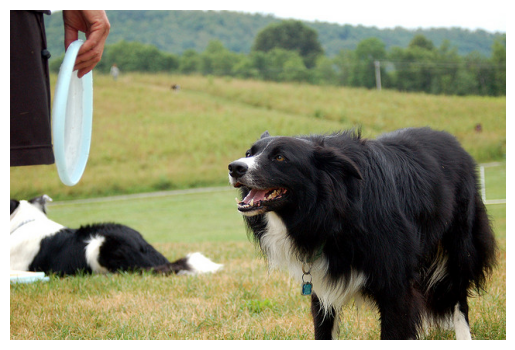

Question: Is the dog waiting?
Answers: yes, yes, yes


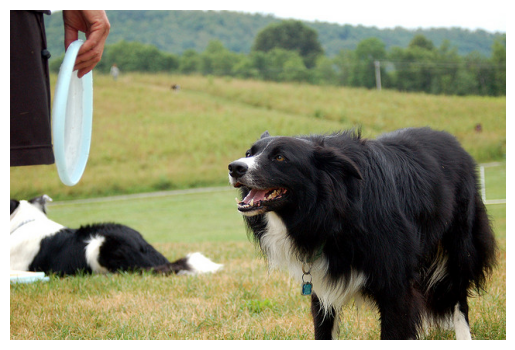

Question: Is the dog looking at a tennis ball or frisbee?
Answers: frisbee, frisbee, frisbee


In [2]:
# Load the dataset JSON file
with open('dataset/dataset/dataset.json', 'r') as f:
    dataset = json.load(f)['data']

# Display images along with their respective questions and answers
for item in dataset:
    image_path = f"dataset/dataset/images/{item['image_id']}.jpg"
    question = item['question']
    answers = item['answers']

    # Display the image if it exists
    if os.path.exists(image_path):
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Display the question and answers
    print(f"Question: {question}")
    print(f"Answers: {', '.join(answers)}")


**Step 3: BERT Model Preparation for Ambiguity Detection**

In [3]:
# Initialize BERT tokenizer and model for ambiguity detection
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Generate clarification questions based on answer consistency
for item in dataset:
    question = item['question']
    answers = item['answers']

    # If answers are inconsistent, generate a clarification question
    if len(set(answers)) > 1:
        clarification_question = f"Could you clarify what you mean by '{question}'?"
        print(f"Original Question: {question}")
        print(f"Clarification Question: {clarification_question}")
    else:
        print(f"Question is clear: {question}")
        print(f"Answer: {answers[0]}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Question is clear: What is this photo taken looking through?
Answer: net
Original Question: What position is this man playing?
Clarification Question: Could you clarify what you mean by 'What position is this man playing?'?
Question is clear: What color is the players shirt?
Answer: orange
Question is clear: Is this man a professional baseball player?
Answer: yes
Question is clear: What color is the snow?
Answer: white
Question is clear: What is the person doing?
Answer: skiing
Original Question: What color is the persons headwear?
Clarification Question: Could you clarify what you mean by 'What color is the persons headwear?'?
Original Question: What is in the person's hand?
Clarification Question: Could you clarify what you mean by 'What is in the person's hand?'?
Question is clear: Is the dog waiting?
Answer: yes
Question is clear: Is the dog looking at a tennis ball or frisbee?
Answer: frisbee


**Step 4: Image Feature Extraction using MobileNet**

In [4]:
# Set up MobileNet model for image feature extraction
mobilenet_model = models.mobilenet_v2(pretrained=True)
mobilenet_model.eval()
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define function to extract image features
def extract_image_features(image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = image_transform(img).unsqueeze(0)
    with torch.no_grad():
        features = mobilenet_model(img_tensor)
    return features

# Apply feature extraction to each image in the dataset
for item in dataset:
    image_path = f"dataset/dataset/images/{item['image_id']}.jpg"
    if os.path.exists(image_path):
        features = extract_image_features(image_path)
        print(f"Extracted features for Image ID {item['image_id']}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 85.6MB/s]


Extracted features for Image ID 000000458752
Extracted features for Image ID 000000458752
Extracted features for Image ID 000000458752
Extracted features for Image ID 000000458752
Extracted features for Image ID 000000262146
Extracted features for Image ID 000000262146
Extracted features for Image ID 000000262146
Extracted features for Image ID 000000524291
Extracted features for Image ID 000000524291
Extracted features for Image ID 000000524291


**Step 5: Decision Layer to Provide Final Answer or Clarification**

In [5]:
# Decision layer function to decide if clarification is needed or to provide the final answer
def decision_layer(question, answers, clarification_question):
    # If all answers are consistent, return the answer directly
    if len(set(answers)) == 1:
        return f"Answer: {answers[0]}"
    # If answers are inconsistent, return the clarification question
    else:
        return clarification_question

# Apply the decision layer for each question in the dataset
for item in dataset:
    question = item['question']
    answers = item['answers']
    clarification_question = f"Could you clarify what you mean by '{question}'?"
    result = decision_layer(question, answers, clarification_question)
    print(f"Result for question '{question}': {result}")


Result for question 'What is this photo taken looking through?': Answer: net
Result for question 'What position is this man playing?': Could you clarify what you mean by 'What position is this man playing?'?
Result for question 'What color is the players shirt?': Answer: orange
Result for question 'Is this man a professional baseball player?': Answer: yes
Result for question 'What color is the snow?': Answer: white
Result for question 'What is the person doing?': Answer: skiing
Result for question 'What color is the persons headwear?': Could you clarify what you mean by 'What color is the persons headwear?'?
Result for question 'What is in the person's hand?': Could you clarify what you mean by 'What is in the person's hand?'?
Result for question 'Is the dog waiting?': Answer: yes
Result for question 'Is the dog looking at a tennis ball or frisbee?': Answer: frisbee
